Centre géographique des 3 villages :
Longitude : -16.48435
Latitude  : 14.52442


/var/folders/_t/1b5pb5492xl5wggbfsqmpp780000gn/T/ipykernel_69060/1953835666.py:132: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  centroid = gdf.unary_union.centroid
/var/folders/_t/1b5pb5492xl5wggbfsqmpp780000gn/T/ipykernel_69060/1953835666.py:150: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  plt.legend()
/var/folders/_t/1b5pb5492xl5wggbfsqmpp780000gn/T/ipykernel_69060/1953835666.py:150: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


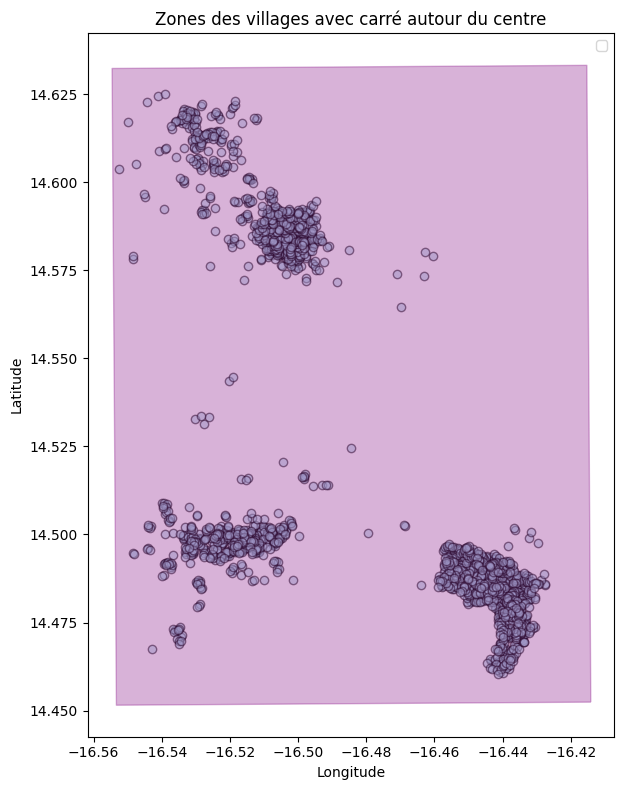

Superficie du rectangle : 300,000,000 m²  (~300.000 km²)

Sommets du rectangle (lon, lat) :
  P1: (-16.414303, 14.452539)
  P2: (-16.415454, 14.633316)
  P3: (-16.554697, 14.632428)
  P4: (-16.553433, 14.451663)

BBOX WGS84  [min_lon, min_lat, max_lon, max_lat] : [-16.554697, 14.451663, -16.414303, 14.633316]

Longueurs des arêtes (m) dans l'ordre du polygone :
  côté 1: 20,000.00 m
  côté 2: 15,000.00 m
  côté 3: 20,000.00 m
  côté 4: 15,000.00 m

Centre du rectangle : lon=-16.484471, lat=14.542499
Maille: 250 m
Nombre de cases (entières + partielles) : 4876
Nombre de cases ENTIERES                : 4800
Surface couverte par la grille (clip)   : 300,000,000 m²  (~300.000 km²)


/var/folders/_t/1b5pb5492xl5wggbfsqmpp780000gn/T/ipykernel_69060/1953835666.py:218: UserWarning: `keep_geom_type=True` in overlay resulted in 35 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  grid_clip = gpd.overlay(grid, gpd.GeoDataFrame(geometry=[rect_utm], crs="EPSG:32628"), how="intersection")
/var/folders/_t/1b5pb5492xl5wggbfsqmpp780000gn/T/ipykernel_69060/1953835666.py:243: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  ax.legend()


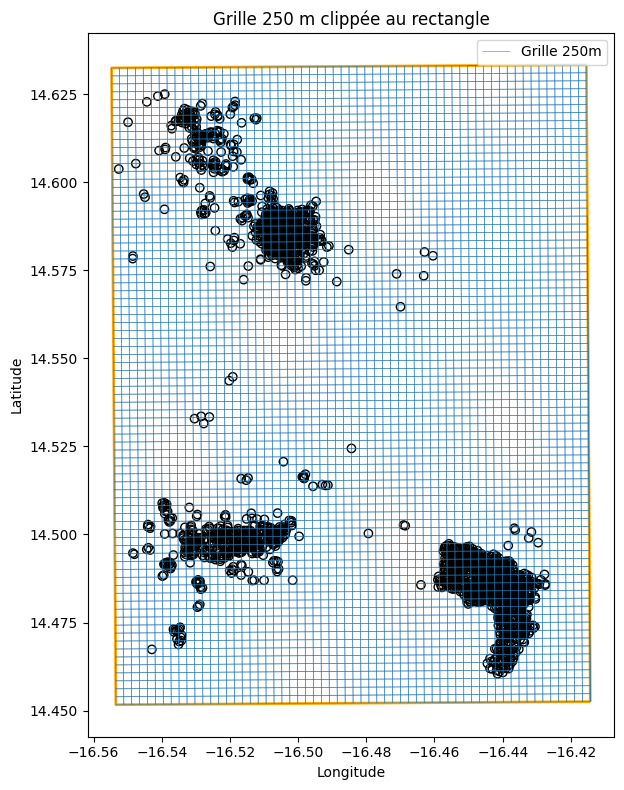

In [4]:
import geopandas as gpd
from shapely.geometry import Point, box
from shapely import affinity
import geopandas as gpd
from shapely.geometry import Point
import pandas as pd
import matplotlib.pyplot as plt
from pyproj import Transformer
import geopandas as gpd
from shapely.geometry import Point
import pandas as pd
import matplotlib.pyplot as plt
from pyproj import Transformer
import numpy as np
from shapely.geometry import box
# Données des villages (longitude, latitude)
# Données des villages (longitude, latitude)
villages = [
    {"name": "Bary", "lon":  -16.51468, "lat": 14.58993},
    {"name": "Diohine/Sassem", "lon": -16.50194, "lat":14.50389},
    {"name": "Sop", "lat": 14.48797, "lon": -16.44108},
    {"name": "centre", "lon": -16.48435, "lat":14.52442}

]


geometry = [Point(v["lon"], v["lat"]) for v in villages]
names = [v["name"] for v in villages]

# Lecture des prélèvements
df = pd.read_csv("../data/use/ird/map_longitude_latitude_profile_id.csv")
cpt = 0
for lon_lat in df["Longitude_Latitude"]:
    lon, lat = map(float, lon_lat.strip("()").split(","))
    geometry.append(Point(lon, lat))
    names.append(f"Prelevement_{cpt}")
    cpt += 1

# Créer le GeoDataFrame
gdf = gpd.GeoDataFrame({"name": names}, geometry=geometry, crs="EPSG:4326")


def rectangle_around_point(point_gdf_utm: gpd.GeoDataFrame,
                           width_m: float = 10000,
                           height_m: float = 6000,
                           dx_m: float = 0,
                           dy_m: float = 0,
                           angle_deg: float = 0) -> gpd.GeoSeries:
    """
    Crée un rectangle (largeur x hauteur en mètres) centré autour d’un point (en UTM).
    - width_m : largeur (Est-Ouest)
    - height_m : hauteur (Nord-Sud)
    - dx_m / dy_m : décalage en mètres
    - angle_deg : rotation en degrés (0 = aligné aux axes)
    Retourne une GeoSeries en WGS84 (EPSG:4326).
    """
    pt = point_gdf_utm.geometry.iloc[0]
    cx, cy = pt.x + dx_m, pt.y + dy_m

    half_w, half_h = width_m / 2.0, height_m / 2.0
    rect = box(cx - half_w, cy - half_h, cx + half_w, cy + half_h)

    if angle_deg != 0:
        rect = affinity.rotate(rect, angle_deg, origin=(cx, cy), use_radians=False)

    return gpd.GeoSeries([rect], crs="EPSG:32628").to_crs(epsg=4326)

# ---------- carré paramétrable autour du centre ----------
def square_around_point(point_gdf_utm: gpd.GeoDataFrame,
                        side_m: float = 15000,
                        dx_m: float = 0,
                        dy_m: float = 0,
                        angle_deg: float = 0) -> gpd.GeoSeries:
    """
    Crée un carré (en mètres, en UTM) autour du point fourni (déjà en UTM),
    avec décalages dx/dy (en mètres) et rotation optionnelle en degrés.
    Retourne une GeoSeries en WGS84 (EPSG:4326) pour l'affichage.
    """
    assert point_gdf_utm.crs.to_epsg() == 32628, "Le point doit être en UTM 28N (EPSG:32628)."

    # Récupère les coords du centre
    pt = point_gdf_utm.geometry.iloc[0]
    cx, cy = pt.x + dx_m, pt.y + dy_m

    half = side_m / 2.0
    sq = box(cx - half, cy - half, cx + half, cy + half)  # carré non-roté

    # Rotation autour de son centre si demandé
    if angle_deg != 0:
        sq = affinity.rotate(sq, angle_deg, origin=(cx, cy), use_radians=False)

    # Retour en WGS84 pour afficher sur la carte
    return gpd.GeoSeries([sq], crs="EPSG:32628").to_crs(epsg=4326)

# --- Tes reprojections déjà faites ---
gdf_utm = gdf.to_crs(epsg=32628)
bary   = gdf_utm[gdf_utm["name"] == "Bary"]
sop    = gdf_utm[gdf_utm["name"] == "Sop"]
centre = gdf_utm[gdf_utm["name"] == "centre"]
Diohine = gdf_utm[gdf_utm["name"] == "Diohine/Sassem"]

# Buffers (en mètres, restent comme tu veux)
bary_buffer_utm    = bary.buffer(5000)
sop_buffer_utm     = sop.buffer(4000)
diohine_buffer_utm = Diohine.buffer(6000)

# --- NOUVEAU : carré pour le centre ---
# Ajuste ici: side_m (taille), dx_m/dy_m (décalage), angle_deg (rotation)
centre_square = square_around_point(
    centre,
    side_m=15000,   # côté du carré en mètres
    dx_m=0,         # décalage Est-Ouest (+ vers l'Est)
    dy_m=0,         # décalage Nord-Sud (+ vers le Nord)
    angle_deg=0     # rotation (0 = aligné N/E)
)

centre_rectangle = rectangle_around_point(
    centre,
    width_m=15000,   # largeur (mètres Est-Ouest)
    height_m=20000,  # hauteur (mètres Nord-Sud)
    dx_m=0,          # décalage Est-Ouest
    dy_m=2000,          # décalage Nord-Sud
    angle_deg=0      # rotation éventuelle
)

# Reprojections des buffers pour affichage
bary_buffer    = gpd.GeoSeries(bary_buffer_utm, crs="EPSG:32628").to_crs(epsg=4326)
sop_buffer     = gpd.GeoSeries(sop_buffer_utm, crs="EPSG:32628").to_crs(epsg=4326)
diohine_buffer = gpd.GeoSeries(diohine_buffer_utm, crs="EPSG:32628").to_crs(epsg=4326)

# Centre géographique (inchangé)
centroid = gdf.unary_union.centroid
print("Centre géographique des 3 villages :")
print(f"Longitude : {centroid.x:.5f}")
print(f"Latitude  : {centroid.y:.5f}")

# --- Plot ---
fig, ax = plt.subplots(figsize=(8, 8))
gdf.plot(ax=ax, edgecolor='black', facecolor='lightblue', alpha=0.5)

# bary_buffer.plot(ax=ax, color='red', alpha=0.3, edgecolor='red', label='Bary buffer')
# sop_buffer.plot(ax=ax, color='green', alpha=0.3, edgecolor='green', label='Sop buffer')
# diohine_buffer.plot(ax=ax, color='blue', alpha=0.3, edgecolor='blue', label='Diohine buffer')

# # carré du centre (remplace l'ancien centre_buffer)
# centre_square.plot(ax=ax, color='yellow', alpha=0.3, edgecolor='orange', label='Centre carré')
centre_rectangle.plot(ax=ax, color='purple', alpha=0.3, edgecolor='purple', label='Centre rectangle')

plt.title("Zones des villages avec carré autour du centre")
plt.legend()
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.tight_layout()
plt.show()


# --- Infos géométriques du rectangle ---
# centre_rectangle est une GeoSeries en WGS84 (EPSG:4326) créée plus haut
rect_wgs = centre_rectangle
rect_utm = centre_rectangle.to_crs(epsg=32628)   # pour les mesures en mètres

# 1) Superficie
area_m2  = float(rect_utm.area.iloc[0])
area_km2 = area_m2 / 1e6
print(f"Superficie du rectangle : {area_m2:,.0f} m²  (~{area_km2:.3f} km²)")

# 2) Coordonnées des sommets (ordre du polygone) en lon/lat
coords_lonlat = list(rect_wgs.geometry.iloc[0].exterior.coords)[:-1]  # on enlève le dernier (répété)
print("\nSommets du rectangle (lon, lat) :")
for i, (x, y) in enumerate(coords_lonlat, 1):
    print(f"  P{i}: ({x:.6f}, {y:.6f})")

# 3) BBOX (minx, miny, maxx, maxy) en lon/lat
minx, miny, maxx, maxy = rect_wgs.total_bounds
print(f"\nBBOX WGS84  [min_lon, min_lat, max_lon, max_lat] : "
      f"[{minx:.6f}, {miny:.6f}, {maxx:.6f}, {maxy:.6f}]")

# 4) Largeur/Hauteur (en mètres) calculées sur les arêtes réelles (OK même si rotation)
ring_utm = list(rect_utm.geometry.iloc[0].exterior.coords)
# ring_utm contient 5 points (le premier répété à la fin)
edges_m = []
for (x1, y1), (x2, y2) in zip(ring_utm[:-1], ring_utm[1:]):
    edges_m.append(((x2 - x1)**2 + (y2 - y1)**2) ** 0.5)

# Les côtés opposés sont (en théorie) égaux ; on regroupe par paire
# (si le rectangle n'est pas parfait à cause de proj/rotations, on affiche tout)
print("\nLongueurs des arêtes (m) dans l'ordre du polygone :")
for i, e in enumerate(edges_m, 1):
    print(f"  côté {i}: {e:,.2f} m")

# Optionnel: centre du rectangle
centroid = rect_wgs.geometry.iloc[0].centroid
print(f"\nCentre du rectangle : lon={centroid.x:.6f}, lat={centroid.y:.6f}")
import numpy as np
import geopandas as gpd
from shapely.geometry import box

# --- Paramètres ---
CELL = 250  # taille de la maille en mètres

# 1) Passer en UTM (mètres) pour générer une grille métrique
rect_wgs = centre_rectangle                     # GeoSeries (1 polygone) en EPSG:4326
rect_utm = rect_wgs.to_crs(epsg=32628).geometry.iloc[0]   # Polygon en EPSG:32628

# 2) Grille régulière couvrant la bbox du rectangle (puis clip)
minx, miny, maxx, maxy = rect_utm.bounds
xs = np.arange(minx, maxx, CELL)
ys = np.arange(miny, maxy, CELL)

cells = []
for x in xs:
    for y in ys:
        cells.append(box(x, y, x+CELL, y+CELL))

grid = gpd.GeoDataFrame(geometry=cells, crs="EPSG:32628")

# 3) Clip de la grille au rectangle (conserve les polygones coupés si rectangle tourné)
grid_clip = gpd.overlay(grid, gpd.GeoDataFrame(geometry=[rect_utm], crs="EPSG:32628"), how="intersection")

# 4) Comptages et surfaces
cell_area = CELL * CELL  # m²
grid_clip["area_m2"] = grid_clip.area

n_total = len(grid_clip)                              # cases (entières + partielles)
n_full  = int((np.isclose(grid_clip["area_m2"], cell_area, rtol=0, atol=1e-3)).sum())  # cases entières
area_total_m2 = grid_clip["area_m2"].sum()
area_total_km2 = area_total_m2 / 1e6

print(f"Maille: {CELL} m")
print(f"Nombre de cases (entières + partielles) : {n_total}")
print(f"Nombre de cases ENTIERES                : {n_full}")
print(f"Surface couverte par la grille (clip)   : {area_total_m2:,.0f} m²  (~{area_total_km2:.3f} km²)")

# 5) (Optionnel) repasser en WGS84 pour affichage/export
grid_clip_wgs = grid_clip.to_crs(epsg=4326)

# 6) Plot rapide
ax = gdf.plot(figsize=(7,8), edgecolor='black', facecolor='none')   # tes points/villages en WGS84
rect_wgs.plot(ax=ax, facecolor='none', edgecolor='orange', linewidth=2, label="Rectangle")
grid_clip_wgs.boundary.plot(ax=ax, linewidth=0.5, alpha=0.7, label="Grille 250m")
ax.set_title("Grille 250 m clippée au rectangle")
ax.set_xlabel("Longitude"); ax.set_ylabel("Latitude")
ax.legend()
plt.tight_layout()
plt.show()

# 7) (Optionnel) export
grid_clip_wgs.to_file("grid_250m.geojson", driver="GeoJSON")
grid_clip.to_file("grid_250m.shp")  # en UTM





/var/folders/_t/1b5pb5492xl5wggbfsqmpp780000gn/T/ipykernel_69060/1797103541.py:38: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  hull = gdf_utm.unary_union.convex_hull


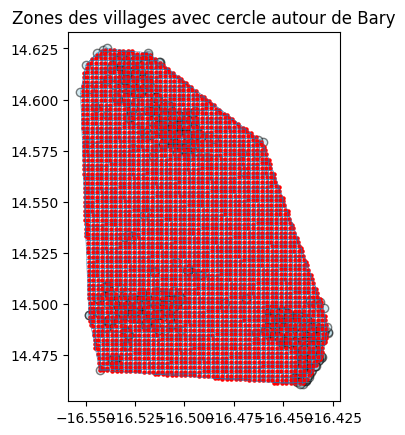

In [1]:

import geopandas as gpd
from shapely.geometry import Point
import pandas as pd
import matplotlib.pyplot as plt
from pyproj import Transformer
import numpy as np
from shapely.geometry import box
# Données des villages (longitude, latitude)


geometry = []
names = []

# Lecture des prélèvements
df = pd.read_csv("../data/use/ird/map_longitude_latitude_profile_id.csv")
cpt = 0
for lon_lat in df["Longitude_Latitude"]:
    lon, lat = map(float, lon_lat.strip("()").split(","))
    geometry.append(Point(lon, lat))
    names.append(f"Prelevement_{cpt}")
    cpt += 1

# Créer le GeoDataFrame
gdf = gpd.GeoDataFrame({"name": names}, geometry=geometry, crs="EPSG:4326")

# Extraire Bary et reprojeter temporairement en UTM (ex. zone 28N)
gdf_utm = gdf.to_crs(epsg=32628)







CELL = 250  # mètres

# emprise = convex hull des points en UTM
hull = gdf_utm.unary_union.convex_hull

# bornes alignées sur la grille
minx, miny, maxx, maxy = hull.bounds
minx = np.floor(minx / CELL) * CELL
miny = np.floor(miny / CELL) * CELL
maxx = np.ceil(maxx / CELL) * CELL
maxy = np.ceil(maxy / CELL) * CELL

# génération des cellules 250 m, découpées à l'emprise
cells = []
xs = np.arange(minx, maxx, CELL)
ys = np.arange(miny, maxy, CELL)
for x in xs:
    for y in ys:
        c = box(x, y, x + CELL, y + CELL)
        if c.intersects(hull):
            cells.append(c.intersection(hull))

grid_utm = gpd.GeoDataFrame(geometry=cells, crs=gdf_utm.crs)
grid_ll = grid_utm.to_crs(epsg=4326)


# créer les centroïdes en UTM
centroids_utm = grid_utm.copy()
centroids_utm["geometry"] = centroids_utm.geometry.centroid

# reprojeter en WGS84 (lat/lon) pour affichage
centroids_ll = centroids_utm.to_crs(epsg=4326)


# === Export des centroïdes en CSV ===
# ajouter un id unique pour chaque cellule
centroids_ll = centroids_ll.reset_index(drop=True)
centroids_ll["id"] = centroids_ll.index + 1
centroids_ll["lon"] = centroids_ll.geometry.x
centroids_ll["lat"] = centroids_ll.geometry.y

# garder seulement id, lon, lat
centroids_ll[["id", "lon", "lat"]].to_csv("zones_villages.csv", index=False)


# Plot
fig, ax = plt.subplots()
gdf.plot(ax=ax, edgecolor='black', facecolor='lightblue', alpha=0.5)
grid_ll.boundary.plot(ax=ax, linewidth=0.3)
centroids_ll.plot(ax=ax, color="red", markersize=5, label="Centroïdes")
plt.title("Zones des villages avec cercle autour de Bary")
plt.show()

# creer le shp de la grille
grid_ll.to_file("zones_villages.shp")


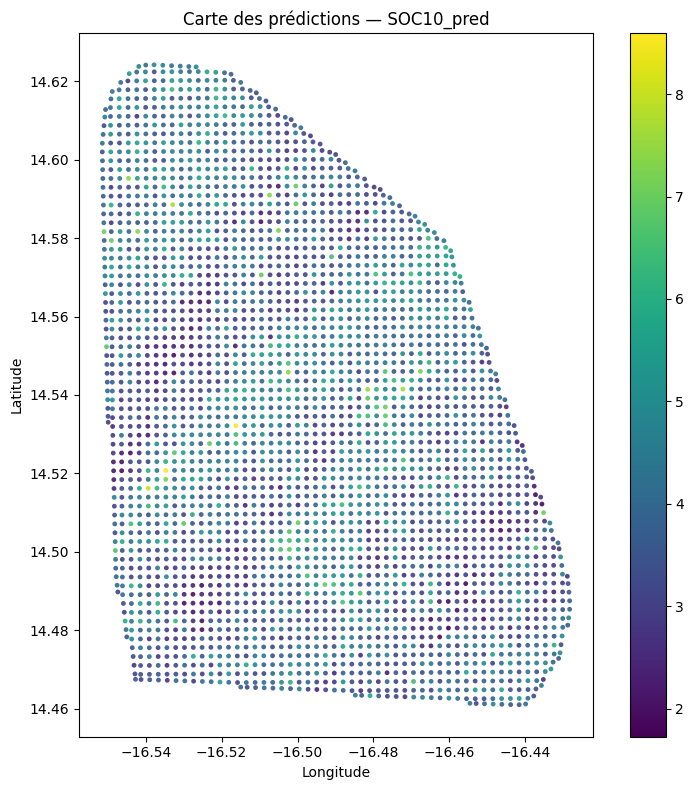

In [ ]:

# ==== PARAMS ====
CSV_PATH   = "data_test_sentinel_landsat_with_predictions.csv"  # ton CSV
VALUE_COL  = "SOC10_pred"  # ou "SOC30_pred"
AoiPath    = None          # ex: "centre_rectangle.geojson" (optionnel)

# 1) Charger CSV -> GeoDataFrame
df = pd.read_csv(CSV_PATH)
gdf = gpd.GeoDataFrame(
    df,
    geometry=gpd.points_from_xy(df["Longitude_x"], df["Latitude_x"], crs="EPSG:4326")
)

if AoiPath:
    aoi = gpd.read_file(AoiPath)                  # doit être un polygone
    if aoi.crs != gdf.crs:
        aoi = aoi.to_crs(gdf.crs)
    gdf = gpd.overlay(gdf, aoi, how="intersection")

# 2) Plot
fig, ax = plt.subplots(figsize=(8, 8))
gdf.plot(
    ax=ax, column=VALUE_COL, legend=True,
    markersize=12, alpha=0.9, cmap="viridis",  # tu peux changer markersize
    edgecolor="none"
)
ax.set_title(f"Carte des prédictions — {VALUE_COL}")
ax.set_xlabel("Longitude"); ax.set_ylabel("Latitude")
plt.tight_layout()
plt.show()


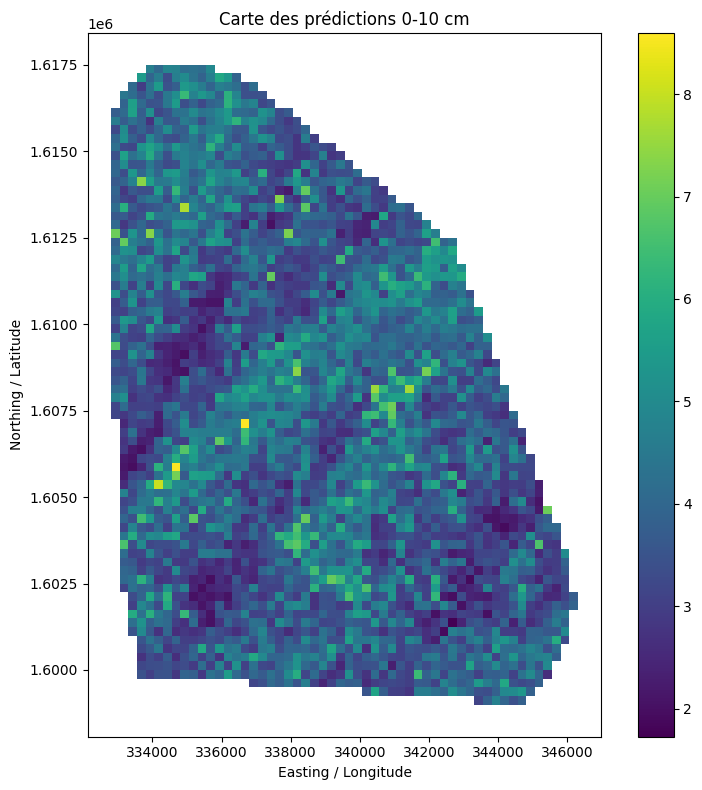

In [7]:

CSV_PATH = "data_test_sentinel_landsat_with_predictions.csv"
GRID_PATH = "grid_250m.shp"      
VALUE_COL = "SOC10_pred"         

# 1) Charger
df = pd.read_csv(CSV_PATH)
pts = gpd.GeoDataFrame(
    df,
    geometry=gpd.points_from_xy(df["Longitude_x"], df["Latitude_x"]),
    crs="EPSG:4326"
)

grid = gpd.read_file(GRID_PATH)
if grid.crs is None:
    # Si la grille est en UTM 28N normalement:
    grid.set_crs(epsg=32628, inplace=True)

# Mettre les points dans le CRS de la grille pour un spatial join correct
pts_utm = pts.to_crs(grid.crs)

# 2) Associer chaque point à sa cellule (sjoin)
joined = gpd.sjoin(pts_utm, grid[["geometry"]].reset_index().rename(columns={"index":"cell_id"}),
                   how="inner", predicate="within")

# 3) Agréger par cellule (moyenne)
agg = joined.groupby("cell_id")[VALUE_COL].mean().reset_index()

# 4) Joindre à la grille et plot
grid2 = grid.reset_index().rename(columns={"index":"cell_id"}).merge(agg, on="cell_id", how="left")

fig, ax = plt.subplots(figsize=(8, 8))
grid2.plot(ax=ax, column=VALUE_COL, cmap="viridis", legend=True, edgecolor="none")
ax.set_title(f"Carte des prédictions 0-10 cm")
ax.set_xlabel("Easting / Longitude"); ax.set_ylabel("Northing / Latitude")
plt.tight_layout()
plt.show()

# (Optionnel) export de la carte en GeoJSON (WGS84)
grid2.to_crs(epsg=4326).to_file(f"grid_250m_{VALUE_COL}_map.geojson", driver="GeoJSON")


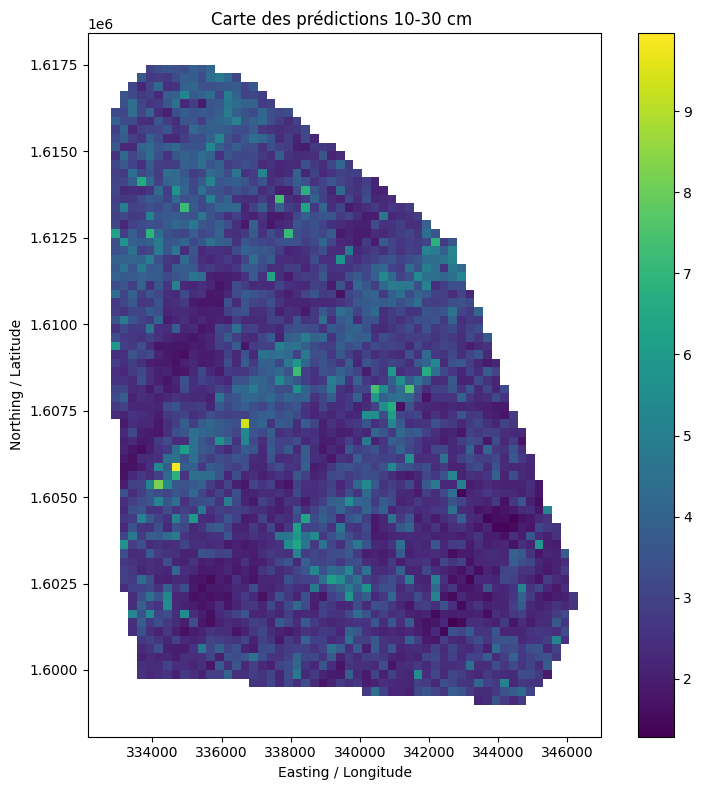

In [8]:
CSV_PATH = "data_test_sentinel_landsat_with_predictions.csv"
GRID_PATH = "grid_250m.shp"      
VALUE_COL = "SOC30_pred"         

# 1) Charger
df = pd.read_csv(CSV_PATH)
pts = gpd.GeoDataFrame(
    df,
    geometry=gpd.points_from_xy(df["Longitude_x"], df["Latitude_x"]),
    crs="EPSG:4326"
)

grid = gpd.read_file(GRID_PATH)
if grid.crs is None:
    # Si la grille est en UTM 28N normalement:
    grid.set_crs(epsg=32628, inplace=True)

# Mettre les points dans le CRS de la grille pour un spatial join correct
pts_utm = pts.to_crs(grid.crs)

# 2) Associer chaque point à sa cellule (sjoin)
joined = gpd.sjoin(pts_utm, grid[["geometry"]].reset_index().rename(columns={"index":"cell_id"}),
                   how="inner", predicate="within")

# 3) Agréger par cellule (moyenne)
agg = joined.groupby("cell_id")[VALUE_COL].mean().reset_index()

# 4) Joindre à la grille et plot
grid2 = grid.reset_index().rename(columns={"index":"cell_id"}).merge(agg, on="cell_id", how="left")

fig, ax = plt.subplots(figsize=(8, 8))
grid2.plot(ax=ax, column=VALUE_COL, cmap="viridis", legend=True, edgecolor="none")
ax.set_title(f"Carte des prédictions 10-30 cm ")
ax.set_xlabel("Easting / Longitude"); ax.set_ylabel("Northing / Latitude")
plt.tight_layout()
plt.show()

# (Optionnel) export de la carte en GeoJSON (WGS84)
grid2.to_crs(epsg=4326).to_file(f"grid_250m_{VALUE_COL}_map.geojson", driver="GeoJSON")

In [11]:
pts.to_file("soc_predictions_points.geojson", driver="GeoJSON")


In [9]:
import geopandas as gpd
import pandas as pd

# Charger la grille
grid = gpd.read_file("zones_villages.shp")  # CRS probable = EPSG:32628 (UTM, en mètres)
if grid.crs is None:
    grid = grid.set_crs(epsg=32628)

# Charger ton CSV de prédictions
df = pd.read_csv("data_test_sentinel_landsat_with_predictions.csv")

# Convertir en GeoDataFrame (points en WGS84)
points = gpd.GeoDataFrame(
    df,
    geometry=gpd.points_from_xy(df["Longitude_x"], df["Latitude_x"]),
    crs="EPSG:4326"
)

# Reprojeter les points dans le même CRS que la grille
points = points.to_crs(grid.crs)

# Associer chaque point au polygone de la grille (join spatial)
joined = gpd.sjoin(points, grid.reset_index().rename(columns={"index":"cell_id"}),
                   how="left", predicate="within")

# Moyenne par maille (si plusieurs points tombent dans la même cellule)
agg = joined.groupby("cell_id")[["SOC10_pred", "SOC30_pred"]].mean().reset_index()

# Joindre les résultats à la grille
grid_out = grid.reset_index().rename(columns={"index":"cell_id"}).merge(agg, on="cell_id", how="left")

# Sauvegarde en Shapefile et GeoJSON
grid_out.to_file("grid_250m_with_soc.shp")
grid_out.to_crs(epsg=4326).to_file("grid_250m_with_soc.geojson", driver="GeoJSON")

print(" SOC10_pred et SOC30_pred ajoutés dans grid_250m_with_soc.shp")


DataSourceError: zones_villages.shp: No such file or directory

In [14]:
import geopandas as gpd
import numpy as np
import rasterio
from rasterio.transform import from_origin
from rasterio.features import rasterize

# Exemple depuis une grille polygonale (grid_250m.shp) avec colonne SOC10_pred
grid = gpd.read_file("grid_250m_with_soc.shp")           # CRS métrique (ex. EPSG:32628)
grid = grid.to_crs(32628)
value_col = "SOC10_pred"                        # assure-toi que cette colonne existe

# Définis la résolution désirée (ex. 250 m)
res = 250
minx, miny, maxx, maxy = grid.total_bounds
width  = int(np.ceil((maxx - minx) / res))
height = int(np.ceil((maxy - miny) / res))
transform = from_origin(minx, maxy, res, res)

# (geom, value) pairs
shapes = [(geom, float(val)) for geom, val in zip(grid.geometry, grid[value_col])]



arr = rasterize(
    shapes=shapes, out_shape=(height, width),
    transform=transform, fill=np.nan, all_touched=True, dtype="float32"
)

profile = {
    "driver": "GTiff",
    "height": height,
    "width": width,
    "count": 1,
    "dtype": "float32",
    "transform": transform,
    "crs": "EPSG:32628",
    "nodata": np.nan
}

with rasterio.open("soc10_tmp.tif", "w", **profile) as dst:
    dst.write(arr, 1)


In [15]:
!gdal_translate -of COG -co COMPRESS=LZW -co NUM_THREADS=ALL_CPUS \
  -co BLOCKSIZE=512 -co OVERVIEWS=AUTO soc10_tmp.tif soc10.tif


Input file size is 54, 74
0...10...20...30...40...50...60...70...80...90...100 - done.
